## Análise com recorte temporal (Pré Galácticos)

**Disciplina: Redes Sociais**

**Grupo: Antonio Fuziy, Eiki Yamashiro e Marcelo Cesário**

___


#### Importação das bibliotecas

In [1]:
import pandas as pd
import os
from graph_tool import Graph, stats, spectral,centrality
import statsmodels.formula.api as smf

from netpixi.data.gt import *
import netpixi
import cpnet
import seaborn as sns
from math import sqrt
from matplotlib import rcParams
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import norm
import difflib
import seaborn as sns
from matplotlib import rcParams

#### Ligas disponíveis

O dataset de transferências possui os dados das seguintes ligas:

#### Problemas:

- Sub21 e Sub18
DATA_DIR = './data/transfers_master/data'- Incoerência entre as colunas club_name e club_involved_name

In [2]:
DATA_DIR = './data/transfers_master/data'
os.listdir(DATA_DIR + '/' + '2014')

['spanish_primera_division.csv',
 'dutch_eredivisie.csv',
 'portugese_liga_nos.csv',
 'french_ligue_1.csv',
 'italian_serie_a.csv',
 'russian_premier_liga.csv',
 'english_premier_league.csv',
 'english_championship.csv',
 'german_bundesliga_1.csv']

#### Loading Data

Função para carregar o dataset. Recebe o diretório que o data está salvo e o ano.

In [3]:
def loading_data(DATA_DIR, year):
    
    # Leitura do primeiro dataset para carregar as columns
    primeiro = 0
    # Loop desconsidera o primeiro elemento (carregado no código acima)
    for league in os.listdir(DATA_DIR + '/' + year)[0:]:
            string = (DATA_DIR + '/' + year + '/' + league)
            data_temp = pd.read_csv(string)
            if primeiro == 0:
                data = data_temp
                primeiro = 1
            else:
                # Concatenação dos dados
                data = pd.concat([data, data_temp])
     
    return(data)

def concat_year(start, end, DATA_DIR, data):
    
    for year in range(start, end+1):
        data = pd.concat([data, loading_data(DATA_DIR, str(year))])
        
    return data

In [4]:
DATA_DIR = './data/transfers_master/data'
YEAR = '1992'

data = loading_data(DATA_DIR, YEAR)
# data

In [5]:
data = concat_year(1993, 2015, DATA_DIR, data)

In [6]:
data_in = data.loc[data["transfer_movement"] == "in"]
data_out = data.loc[data["transfer_movement"] == "out"]
data_in = data_in.reset_index()
data_out = data_out.reset_index()

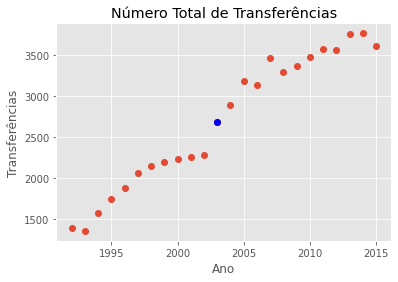

In [7]:
import matplotlib.pyplot as plt

pl = data_in["year"].value_counts()
pre_gal = pl.sort_index()
pos_gal = pl.sort_index()
pre_gal = pre_gal[:11]
pos_gal = pos_gal[11:]

plt.style.use('ggplot')
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.plot(pl.sort_index(), 'o', label = "Transferências")
plt.plot(2003 ,pl[2003], 'bo', label = "Era");

## Pré-Galácticos e Pós-Galacticos

O gráfico acima mostra a evolução no número de transferências de jogadores ao longo dos anos, dessa forma pode-se perceber que 2003 foi o ano em que houve a maior evolução no número de movimentações no mercado do futebol europeu da história. Portanto, deixou-se essa data como destaque em azul no gráfico, marcando o fim da era dos galácticos e o começo da era pós galácticos.

Assim, como o segundo gráfico mostra os anos em rosa que indicam a era pré-galácticos e os em azul a era pós-galácticos. 

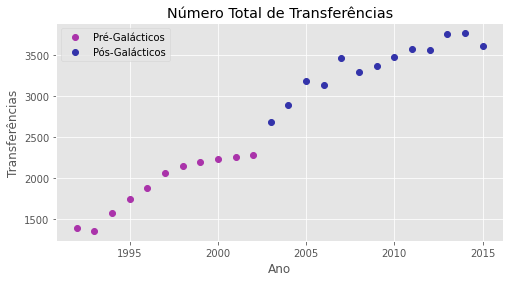

In [8]:
plt.figure(figsize = (8,4))
plt.plot(pre_gal, 'o', label = "Pré-Galácticos", color = "#AA33AA")
plt.plot(pos_gal, 'o', label = "Pós-Galácticos", color = "#3333AA")
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.legend(loc="upper left")
plt.show()

In [9]:
in_names = list(data_in["club_name"].value_counts().index)
out_names = list(data_in["club_involved_name"].value_counts().index)
name_dic = {}
problems = ["Olympique Marseille", "Olympique Lyon", "Eintracht Braunschweig", "Eintracht Frankfurt"]
for in_str in in_names:
    for out_str in out_names:

        if out_str[:10] in in_str and out_str != in_str:
            if (out_str not in problems) or (in_str not in problems):
#                 print(in_str ,", ", out_str)
                name_dic[out_str] = in_str

In [10]:
for k,v in name_dic.items():
    data_in["club_involved_name"].replace({k: v}, inplace=True)
    
# data_in

In [11]:
data_pre_gal = data_in[data_in["year"] <= 2003]
data_pos_gal =  data_in[data_in["year"] > 2003]

In [12]:
rede_pre_gal = Graph(directed=True) # dirigido
rede_pre_gal.vp['name'] = rede_pre_gal.new_vp('object')
rede_pre_gal.vp['league'] = rede_pre_gal.new_vp('object')
rede_pre_gal.ep["transfer"] = rede_pre_gal.new_ep('object')

In [13]:
times = []
for index, rows in data_pre_gal.iterrows():
    time1 = rows[1]
    time2 = rows[5]
    if time1 not in times:
        times.append(time1)
        rede_pre_gal.add_vertex()
        v_time = rede_pre_gal.vertex(times.index(time1))
        rede_pre_gal.vp['name'][v_time] = time1
        rede_pre_gal.vp['league'][v_time] = rows[10]
        
    if time2 not in times:
        times.append(time2)
        rede_pre_gal.add_vertex()
        v_time = rede_pre_gal.vertex(times.index(time2))
        rede_pre_gal.vp['name'][v_time] = time2
        rede_pre_gal.vp['league'][v_time] = rows[10]
    
    index1 = times.index(time1)
    index2 = times.index(time2)
    
    if rede_pre_gal.edge(index1, index2) == None:
        rede_pre_gal.add_edge(index1, index2)
        e = rede_pre_gal.edge(index1, index2)
        rede_pre_gal.ep["transfer"][e] = 1
    else:
        e = rede_pre_gal.edge(index1, index2)
        rede_pre_gal.ep["transfer"][e] = rede_pre_gal.ep["transfer"][e] + 1

In [14]:
data_in["league_name"].value_counts()

Championship        12342
Premier League       9652
Serie A              7532
Liga Nos             7382
Ligue 1              6365
Primera Division     5988
Eredivisie           5608
1 Bundesliga         5163
Premier Liga         4923
Name: league_name, dtype: int64

In [15]:
data_in[data_in['league_name']=='Serie A'][0:50]

,index,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
561,0,Milan AC,Jean-Pierre Papin,28.0,Centre-Forward,Olympique Marseille,£10.80m,in,Summer,10.800,Serie A,1992,1992/1993
562,1,Milan AC,Gianluigi Lentini,23.0,Right Winger,Torino Calcio,£8.60m,in,Summer,8.600,Serie A,1992,1992/1993
563,2,Milan AC,Dejan Savicevic,25.0,Attacking Midfield,Red Star,£4.14m,in,Summer,4.140,Serie A,1992,1992/1993
564,3,Milan AC,Guido Bistazzoni,32.0,Goalkeeper,Taranto,?,in,Summer,NaN,Serie A,1992,1992/1993
565,4,Milan AC,Fernando De Napoli,28.0,Central Midfield,SSC Napoli,?,in,Summer,NaN,Serie A,1992,1992/1993
566,5,Milan AC,Davide Dionigi,18.0,Centre-Forward,Modena FC,?,in,Summer,NaN,Serie A,1992,1992/1993
567,6,Milan AC,Stefano Eranio,25.0,Right Midfield,Genoa 1893,?,in,Summer,NaN,Serie A,1992,1992/1993
568,7,Milan AC,Martino Traversa,18.0,Right-Back,Bologna FC 1909,?,in,Summer,NaN,Serie A,1992,1992/1993
569,8,Milan AC,Giuseppe Cardone,18.0,Right-Back,Milan U19,-,in,Summer,0.000,Serie A,1992,1992/1993
570,9,Milan AC,Giuseppe Zappella,19.0,Right-Back,Milan U19,-,in,Summer,0.000,Serie A,1992,1992/1993


In [16]:
rede_pre_gal.vp['color'] = rede_pre_gal.new_vp('object')

for v in rede_pre_gal.vertices():
    if rede_pre_gal.vp['league'][v] == "Premier League":
        rede_pre_gal.vp['color'][v] = 0x61dafb
        #61dafb
    if rede_pre_gal.vp['league'][v] == "Eredivisie":
        rede_pre_gal.vp['color'][v] = 0x915bff
        #915bff
    if rede_pre_gal.vp['league'][v] == "Championship":
        rede_pre_gal.vp['color'][v] = 0xbababa
        #bababa
    if rede_pre_gal.vp['league'][v] == "Serie A":
        rede_pre_gal.vp['color'][v] = 0x00ff00
        #00ff00
    if rede_pre_gal.vp['league'][v] == "Liga Nos":
        rede_pre_gal.vp['color'][v] = 0xffa7b6
        #ffa7b6
    if rede_pre_gal.vp['league'][v] == "Ligue 1":
        rede_pre_gal.vp['color'][v] = 0x0000ff
        #0000ff
    if rede_pre_gal.vp['league'][v] == "1 Bundesliga":
        rede_pre_gal.vp['color'][v] = 0xff0000
        #ff0000
    if rede_pre_gal.vp['league'][v] == "Premier Liga":
        rede_pre_gal.vp['color'][v] = 0x8f2f00
        #8f2f00
    if rede_pre_gal.vp['league'][v] == "Primera Division":
        rede_pre_gal.vp['color'][v] = 0xffda28
        #ffda28
        
stats.remove_self_loops(rede_pre_gal)
m = draw_gt.sfdp_layout(rede_pre_gal)
move_gt(rede_pre_gal, m)
save_gt(rede_pre_gal, 'rede_pre_gal.net.gz')
# r = netpixi.render('exemplo4.net.gz')

In [17]:
def centro_periferia(g, t):
    matrix = spectral.adjacency(g)
    if t == "core":
        algorithm = cpnet.LowRankCore()
    elif t == "coreness":
        algorithm = cpnet.MINRES()

    algorithm.detect(matrix)
    c = algorithm.get_coreness()

    g.vp[t] = g.new_vp('object')
    for i, coreness in c.items():
        v = g.vertex(i)
        g.vp[t][v] = float(coreness)

In [18]:
centro_periferia(rede_pre_gal, "core")

In [19]:
df = pd.DataFrame({k: list(v) for k, v in rede_pre_gal.vp.items()})
df.head()

,name,league,color,_x,_y,core
0,Real Sociedad,Primera Division,16767528,-4.898182,-3.527946,1.0
1,R. Sociedad U19,Primera Division,16767528,-4.855947,-3.315983,0.0
2,Cádiz CF,Primera Division,16767528,-5.016283,-3.457908,0.0
3,Hajduk Split,Primera Division,16767528,-4.895350,-3.596529,0.0
4,CD Málaga,Primera Division,16767528,-5.074807,-3.372631,0.0


In [20]:
df["league"].value_counts()

Premier Liga        372
1 Bundesliga        323
Serie A             296
Liga Nos            292
Eredivisie          287
Ligue 1             271
Premier League      246
Primera Division    218
Championship        170
Name: league, dtype: int64

In [21]:
def plot_cp(df):
    plt.figure(figsize=(16,8))
    plt.plot(df[df["league"] == "Eredivisie"]["_x"], df[df["league"] == "Eredivisie"]["_y"],
             'o', markersize=12, label = "Eredivisie", alpha=.5, color="#915bff")
    plt.plot(df[df["league"] == "Liga Nos"]["_x"], df[df["league"] == "Liga Nos"]["_y"],
             'o', markersize=12, label = "Liga Nos", alpha=.5, color="#ffa7b6")
    plt.plot(df[df["league"] == "Premier Liga"]["_x"], df[df["league"] == "Premier Liga"]["_y"],
             'o', markersize=12, label = "Premier Liga", alpha=.5, color="#8f2f00")
    plt.plot(df[df["league"] == "Championship"]["_x"], df[df["league"] == "Championship"]["_y"],
             'o', markersize=12, label = "Championship", alpha=.5, color="#bababa")
    plt.plot(df[df["league"] == "Serie A"]["_x"], df[df["league"] == "Serie A"]["_y"],
             'o', markersize=12, label = "Serie A", alpha=.5, color="#00ff00")
    plt.plot(df[df["league"] == "Ligue 1"]["_x"], df[df["league"] == "Ligue 1"]["_y"],
             'o', markersize=12, label = "Ligue 1", alpha=.5, color="#0000ff")
    plt.plot(df[df["league"] == "Premier League"]["_x"], df[df["league"] == "Premier League"]["_y"],
             'o', markersize=12, label = "Premier League", alpha=.5, color="#61dafb")
    plt.plot(df[df["league"] == "1 Bundesliga"]["_x"], df[df["league"] == "1 Bundesliga"]["_y"],
             'o', markersize=12, label = "1 Bundesliga", alpha=.5, color="#ff0000")
    plt.plot(df[df["league"] == "Primera Division"]["_x"], df[df["league"] == "Primera Division"]["_y"],
             'o', markersize=12, label = "Primera Division", alpha=.5, color="#ffda28")
    plt.title("Classificação core & liga")
    plt.xlabel("posição em X")
    plt.ylabel("posição em Y")
    plt.legend(loc = "upper right")
    plt.show()

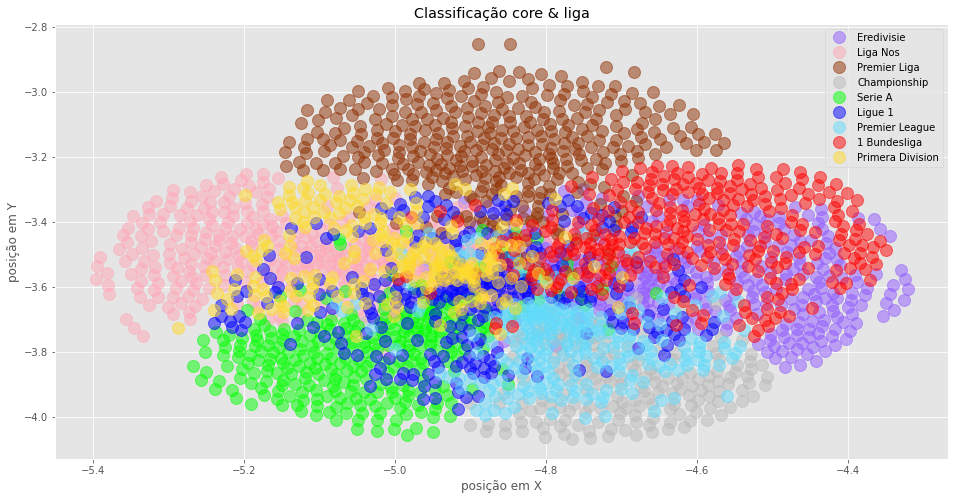

In [22]:
plot_cp(df)

## Conclusão sobre o grafo das tranferências entre clubes europeus

Observando o grafo plotado, é possível observar panelinhas entre as ligas do futebol europeu, fica bem claro a concentração entre os times de mesma liga quando se olha para as cores e os devidos posicionamentos dos vértices ao longo da rede, assim fica mais evidente a possível existência de times que interligam tranferências entre as ligas, os quais corroboram para a hipótese do grupo.

**Hipótese: Times com boa relação com times de diferentes ligas (relacionamento interliga) atingem melhor desempenho na champions league**


In [23]:
def loading_champions_data(DATA_DIR, year, end):
    list_df = []
    str_year = f"{year}-{str(year+1)[-2:]}"
    dir = "./data/champions_league/"+ str_year + "/champs.csv"
    data = pd.read_csv(dir)
    list_df.append(data)
    start = year + 1
    
    for year in range(start, end+1):
        str_year = f"{year}-{str(year+1)[-2:]}"
        dir = "./data/champions_league/"+ str_year + "/champs.csv"
        
        #data = pd.concat([data, pd.read_csv(dir)])
        data = pd.read_csv(dir)
        list_df.append(data)
    return(list_df)

In [24]:
DATA_DIR = './data/champions_league'
YEAR = 1993

list_df = loading_champions_data(DATA_DIR, YEAR, 2003)
list_df[1]


,Stage,Round,Group,Date,Team 1,FT,HT,Team 2,∑FT,ET,P,Comments
0,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),AEK Athens › GRE (1),2-0,0-0,Rangers FC › SCO (1),NaN,NaN,NaN,NaN
1,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Avenir Beggen › LUX (1),1-5,0-0,Galatasaray İstanbul AŞ › TUR (1),NaN,NaN,NaN,NaN
2,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Silkeborg IF › DEN (1),0-0,0-0,Dinamo Kiev › UKR (1),NaN,NaN,NaN,NaN
3,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Paris Saint-Germain › FRA (1),3-0,0-0,Dunakanyar-Vac › HUN (1),NaN,NaN,NaN,NaN
4,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Legia Warsaw › POL (1),0-1,0-0,Hajduk Split › CRO (1),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
72,Knockout,Semifinals | Leg 1,NaN,(Wed) 5 Apr 1995 (W14),Paris Saint-Germain › FRA (11),0-1,0-0,AC Milan › ITA (9),NaN,NaN,NaN,NaN
73,Knockout,Semifinals | Leg 1,NaN,(Wed) 5 Apr 1995 (W14),Bayern München › GER (9),0-0,0-0,AFC Ajax › NED (9),NaN,NaN,NaN,NaN
74,Knockout,Semifinals | Leg 2,NaN,(Wed) 19 Apr 1995 (W16),AFC Ajax › NED (10),5-2,3-1,Bayern München › GER (10),5-2 (agg.),NaN,NaN,NaN
75,Knockout,Semifinals | Leg 2,NaN,(Wed) 19 Apr 1995 (W16),AC Milan › ITA (10),2-0,1-0,Paris Saint-Germain › FRA (12),3-0 (agg.),NaN,NaN,NaN


In [25]:
def calcula_pontos(stage,round_,time1,time2,time1_placar,time2_placar,comentarios,dict_teams):
    pontos_ = 0
    if stage == 'Qualifying':
        pontos_=1
    elif stage == 'Group':
        pontos_=3
    else:
        pontos_ = 5
    if round_ == 'Final':
        pontos_ = 10
    
    
    if time1 not in dict_teams:
        dict_teams[time1] = 0
        
    if time2 not in dict_teams:
        dict_teams[time2] = 0
        
    if comentarios !=0:
        if comentarios == 1:
            time_vencedor = time1
        if comentarios == 2:
            time_vencedor = time2
    
    if time1_placar > time2_placar:
        time_vencedor = time1
    else:
        time_vencedor = time2
    dict_teams[time_vencedor] +=pontos_


In [26]:
dict_teams = {}
for i in range(len(list_df)):
    list_df[i]['Team 1'] = list_df[i]['Team 1'].str.split(' ›').str[0]
    list_df[i]['Team 2'] = list_df[i]['Team 2'].str.split(' ›').str[0]
    #list_df[i] = list_df[i].dropna(subset=['∑FT'])
    # limpando '∑FT'
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace("(","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace(")","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace("a ","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace("agg.","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace(" ","")
    list_df[i]['time1_placar_agregado'] = list_df[i]['∑FT'].str.split('-').str[0]
    list_df[i]['time2_placar_agregado'] = list_df[i]['∑FT'].str.split('-').str[1]
    # limpando P
    list_df[i]['P'] = list_df[i]['P'].astype(str).str.replace('(','')
    list_df[i]['P'] = list_df[i]['P'].astype(str).str.replace(")","", regex=True)
    list_df[i]['P'] = list_df[i]['P'].astype(str).str.replace("pen.","", regex=True)
    list_df[i]['time1_penalti'] = list_df[i]['P'].str.split('-').str[0]
    list_df[i]['time2_penalti'] = list_df[i]['P'].str.split('-').str[1]
    
    # limpando Comments (Away Goals)
    list_df[i]['Comments'] = list_df[i]['Comments'].str.replace('(','')
    list_df[i]['Comments'] = list_df[i]['Comments'].str.replace(')','')
    list_df[i]['Comments'] = list_df[i]['Comments'].str.replace('Away Goals ','')
    
    list_df[i]['time1_placar'] = list_df[i]['FT'].str.split('-').str[0]
    list_df[i]['time1_placar'] = list_df[i]['time1_placar'].str.replace(' ','')
    list_df[i]['time2_placar'] = list_df[i]['FT'].str.split('-').str[1]
    list_df[i] = list_df[i].drop(list_df[i][((list_df[i]['Stage'] == 'Knockout') & (list_df[i]['∑FT'].isnull()) & (list_df[i]['Round'] != 'Final'))].index)

    
    for index, rows in list_df[i].iterrows():
        stage = rows[0]
        round_ = rows[1]
        time1 = rows[4]
        time2 = rows[7]
        comments = rows[11]
        time1_placar_agregado = rows[12]
        time2_placar_agregado = rows[13]
        time1_penalti = rows[14]
        time2_penalti = rows[15]
        time1_placar = rows[16]
        time2_placar = rows[17]
        # checar se houve penalti
        if time1_penalti != 'nan':
            calcula_pontos(stage, round_,time1,time2,int(time1_penalti),int(time2_penalti),0, dict_teams)  
        # checar se teve gol fora de casa 
        elif comments == '1' or comments =='2':
            calcula_pontos(stage, round_,time1,time2,0,0,int(comments),dict_teams)
        # ver se é um jogo com placar agregado
        elif  type(time1_placar_agregado) == str:
            pass
            calcula_pontos(stage, round_,time1,time2,int(time1_placar_agregado),int(time2_placar_agregado),0,dict_teams)
        # passar o placar comum
        else:
            #print(time1_placar[0])
            calcula_pontos(stage, round_,time1,time2,int(time1_placar[0]),int(time2_placar[0]),0,dict_teams)

In [27]:
{k: v for k, v in sorted(dict_teams.items(), key=lambda item: item[1])}


{'Cork City': 0,
 'Avenir Beggen': 0,
 'B68 Toftir': 0,
 'FK Ekranas': 0,
 'FK Partizani Tirana': 0,
 'Kispesti Honved': 0,
 'Silkeborg IF': 0,
 'Dunakanyar-Vac': 0,
 'Servette Geneve': 0,
 'Alania Vladikavkaz': 0,
 'FK Kareda Kaunas': 0,
 'Crusaders': 0,
 'Derry City': 0,
 'Lantana Tallinn': 0,
 'FC Tiraspol': 0,
 'GI Gota': 0,
 'Jeunesse Esch': 0,
 'Neftchi PFC Baku': 0,
 'B36 Torshavn': 0,
 'Cliftonville': 0,
 'FK Vllaznia': 0,
 'FC Yerevan': 0,
 'Flora Tallinn': 0,
 'Kapaz': 0,
 'FC Metz': 0,
 'Araks Ararat': 0,
 'Glentoran': 0,
 'HB': 0,
 'Dnepr Mogilev': 0,
 'SK Slovan Bratislava': 0,
 'Rapid Bucuresti': 0,
 'HNK Rijeka': 0,
 'Teplice': 0,
 'Shirak': 0,
 'Birkirkara': 0,
 'KI Klaksvik': 0,
 'F91 Dudelange': 0,
 'NK Brotnjo': 0,
 'The New Saints': 0,
 'Shamkir': 0,
 'Dinamo Bucuresti': 0,
 'Hapoel Tel Aviv': 0,
 'SSW Innsbruck': 0,
 'St. Gallen': 0,
 'HB Koge': 0,
 'TSV 1860 Munchen': 0,
 'Vagur': 0,
 'Lugano': 0,
 'Astana-64': 0,
 'Portadown': 0,
 'Tampere United': 0,
 'NK Zagreb

In [28]:
#para tirar
list_names_to_remove=[
    'Olimpija Ljubljana','Cwmbran Town','Avenir Beggen',
    'Linfield','FC Norma Tallinn','IA Akranes','AIK Solna','Kispesti Honved',
    'Dunakanyar-Vac','Barry Town','FK Sileks','Crusaders','Lantana Tallinn','FC Jazz',
    'FC Tiraspol','FC Slavia Mozyr','GI Gota','Kosice','Jeunesse Esch','Valletta',
    'B36 Torshavn','FK Vllaznia','FC Yerevan','FK Obilic','IB Vestmannaeyja','Flora Tallinn',
    'KF Tirana','Araks Ararat','Haka Valkeakoski','Dnepr Mogilev','Birkirkara','KR Reykjavik',
    'KI Klaksvik','Crvena Zvezda','NK Brotnjo','Zalgiris Vilnius','The New Saints',
    'Shamkir','Dunaujvaros','Belshina Bobruisk','Dinamo Tirana','Tampere United','FK Leotar',
    'NK Siroki Brijeg','HNK Gorica','PAOK FC','Sioni Bolnisi','FK Modrica','FC Santa Coloma',
    'Drogheda United','FK Mogren','UE Sant Julia','EB / Streymur''Stabaek','Fola Esch','Nomme Kalju'   
]

dict_teams_change={
    'Kobenhavn':'FC Copenhagen',
    'AFC Ajax':'Ajax Amsterdam',
    'Beşiktaş İstanbul JK':'Besiktas',
    'Fenerbahçe İstanbul SK':'Fenerbahce',
    'MTK':'MTK Budapest',
    "St Patrick's Athletic":"St. Patricks",
    "Skonto":"Skonto Riga",
    "Juventus":"Juventus FC",
    "Internazionale":"Inter Milan",
    "FK Zalgiris Vilnius":"Zalgiris",
    "Lille OSC":"LOSC Lille",
    "Vardar Skopje":'Vardar',
    "Celta Vigo":"Celta de Vigo",
    "Kairat":"Kairat Almaty",
    "Dinamo Moskva":'Dinamo Moscow'

}
#count = 0
list_names = []
for name in list(dict_teams.keys()):
    if name not in list(df['name']):
        if name in list_names_to_remove:
            dict_teams.pop(name, None)
        elif name in dict_teams_change:
            dict_teams[dict_teams_change[name]] = dict_teams[name]
            dict_teams.pop(name,None)
        else:
            name_gerado=difflib.get_close_matches(name,list(df['name']),n=1,cutoff=0.5)
            if len(name_gerado)>0:
                dict_teams[name_gerado[0]] = dict_teams[name]
                dict_teams.pop(name,None)
            else:
                print(name)
                dict_teams.pop(name,None)

# # para substituir
# Kobenhavn[FC Copenhagen]
# AFC Ajax[Ajax Amsterdam]
# Beşiktaş İstanbul JK[Besiktas]
# Fenerbahçe İstanbul SK[Fenerbahce]
# MTK[MTK Budapest]
# St Patrick's Athletic[St. Patricks]
#Skonto[Skonto Riga]
#Juventus[Juventus FC]
#Internazionale[Inter Milan],
# FK Zalgiris Vilnius[Zalgiris]
#Lille OSC[LOSC Lille]
#Vardar Skopje[Vardar]
#Celta Vigo[Celta de Vigo]
#Kairat[Kairat Almaty]
#Dinamo Moskva[Dinamo Moscow]

B68 Toftir
Sloga Jugomagnat Skopje
HB


In [29]:
len(dict_teams)

176

In [30]:
list(df['name'])[1151]

'Colo Colo'

In [31]:
from collections import Counter

a = dict(Counter(list_names))
for k,v in a.items():
    if v ==1:
        print(k,v)

In [32]:
difflib.get_close_matches("Ajax Amsterdam",list(df['name']),n=15,cutoff=0.6)

['Ajax Amsterdam', 'DRC Amsterdam', 'Ajax Amateurs']

In [33]:
len(dict_teams)

176

In [34]:
df[df['name'].str.contains("Vardar")]

,name,league,color,_x,_y,core
1533,Vardar,Eredivisie,9526271,-4.430155,-3.635188,0.0


In [35]:
count =0
betweenness, _ = centrality.betweenness(rede_pre_gal)
for v in betweenness:
    print(v)
    if v<0.00001:
        count +=1

0.000633095150068574
0.0
9.449036025798283e-05
0.0
0.0
0.0
0.0007001007506361139
0.0015411344994299186
0.0
0.00037555542150294097
0.00019857823839088275
0.0
7.056390516961666e-05
0.0016849105405694288
0.00019799911717865407
0.0017645526065084185
0.0
0.000425034636183643
0.0008936894528206804
0.0
0.0007890937403351508
0.0
0.0008796768211590432
0.00020321387903946393
0.0
0.0
0.0
0.0
0.0
0.001479567483854091
0.0004825236361486848
0.0007907050445259764
0.0
0.0
0.0
0.0
0.0
0.0007069186726108727
0.0016349040169414226
0.00022585761745990278
0.0013056289455464843
0.0
0.0
0.0005917004173141623
0.0
0.0
0.0
0.0007855321894402332
0.0
0.0
0.0
0.0
0.0014219894953078152
0.0001233166861198177
3.17232584543511e-05
0.0
0.0
0.0
0.0
0.0
0.00012218796154358718
0.00035684611561674027
0.0
0.0017056955406538443
0.0
0.0
0.0
0.0
0.0
0.00091112061107649
0.00046416633554060584
0.0
0.0
0.0
0.0002458412179869933
8.879520235411429e-06
0.0012516789727955032
0.0
0.0
6.472957213073673e-05
0.0
0.0
0.0003429656439730675


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00016837630851268824
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.285787382717774e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00014021322020066346
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [36]:
rede_pre_gal.vp['betweenness'] = betweenness

In [37]:
df = pd.DataFrame({k: list(v) for k, v in rede_pre_gal.vp.items()})

In [38]:
df['pontos'] = 0

In [39]:
for name,pontos in dict_teams.items():
    df.loc[df['name'] == name,'pontos'] = pontos

In [40]:
df

,name,league,color,_x,_y,core,betweenness,pontos
0,Real Sociedad,Primera Division,16767528,-4.898182,-3.527946,1.0,0.000633,9
1,R. Sociedad U19,Primera Division,16767528,-4.855947,-3.315983,0.0,0.000000,0
2,Cádiz CF,Primera Division,16767528,-5.016283,-3.457908,0.0,0.000094,0
3,Hajduk Split,Primera Division,16767528,-4.895350,-3.596529,0.0,0.000000,16
4,CD Málaga,Primera Division,16767528,-5.074807,-3.372631,0.0,0.000000,0
...,...,...,...,...,...,...,...,...
2470,CRAC (GO),1 Bundesliga,16711680,-4.581490,-3.233876,0.0,0.000000,0
2471,W. Burghausen,1 Bundesliga,16711680,-4.548576,-3.605834,0.0,0.000000,0
2472,FB (FCN II),1 Bundesliga,16711680,-4.386181,-3.406903,0.0,0.000000,0
2473,Monterrey,1 Bundesliga,16711680,-4.601308,-3.281122,0.0,0.000000,0


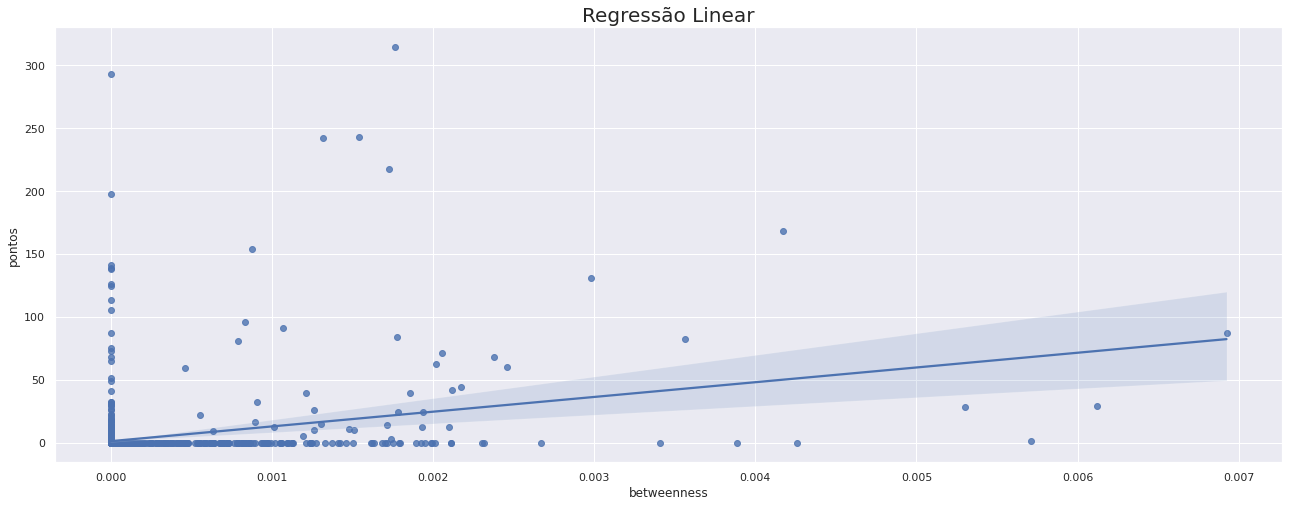

In [41]:
sns.set()

plt.figure(figsize=(22,8))
sns.regplot(x=df['betweenness'], y=df['pontos'])
plt.title("Regressão Linear", fontsize=20)
plt.show()

In [42]:
model = smf.ols(data=df, formula='pontos ~ betweenness')
result_with_zero = model.fit()
result_with_zero.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pontos   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     242.5
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           3.18e-52
Time:                        00:04:40   Log-Likelihood:                -10353.
No. Observations:                2475   AIC:                         2.071e+04
Df Residuals:                    2473   BIC:                         2.072e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.0704      0.327      3.276      0.001       0.430       1.711
betweenness  1.171e+04    751.927     15.571      0.000    1.02e+04    1.32e+04
==============================================================================
Omnibus:                     4139.544   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2679839.520
Skew:                          11.203   Prob(JB):                         0.00
Kurtosis:                     162.638   Cond. No.                     2.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
def linear_resplot(result):
    width, height = rcParams['figure.figsize']
    fig, axs = plt.subplots(1, 2, figsize=(2 * width, height))
    ax = sns.scatterplot(x=result.fittedvalues, y=result.resid, ax=axs[0])
    ax.axhline(0)
    sns.histplot(result.resid, ax=axs[1])
    plt.show()

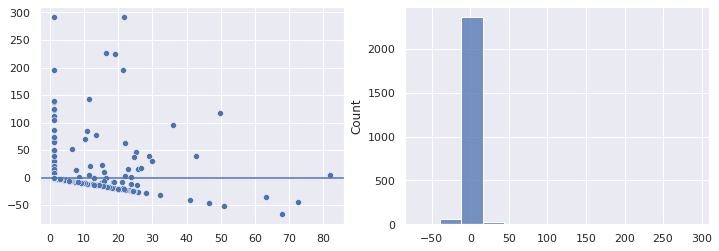

In [44]:
linear_resplot(result_with_zero)

In [45]:
df2 = df[(df['pontos'] > 0)]

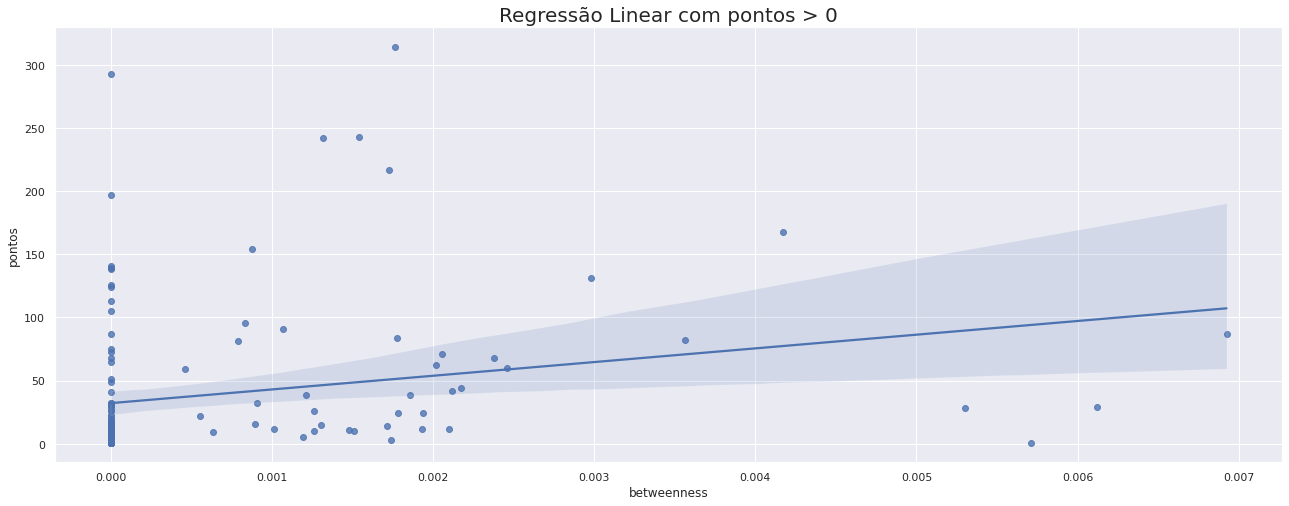

In [46]:
sns.set()
plt.figure(figsize=(22,8))
sns.regplot(x=df2['betweenness'], y=df2['pontos'])
plt.title("Regressão Linear com pontos > 0", fontsize=20)
plt.show()

In [47]:
model = smf.ols(data=df2, formula='pontos ~ betweenness') 
result_not_zero = model.fit()
result_not_zero.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pontos   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     7.537
Date:                Tue, 23 Nov 2021   Prob (F-statistic):            0.00686
Time:                        00:04:41   Log-Likelihood:                -755.62
No. Observations:                 138   AIC:                             1515.
Df Residuals:                     136   BIC:                             1521.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      32.1640      5.538      5.808      0.000      21.213      43.115
betweenness  1.084e+04   3949.916      2.745      0.007    3032.872    1.87e+04
==============================================================================
Omnibus:                       88.814   Durbin-Watson:                   1.328
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              395.095
Skew:                           2.471   Prob(JB):                     1.61e-86
Kurtosis:                       9.655   Cond. No.                         797.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

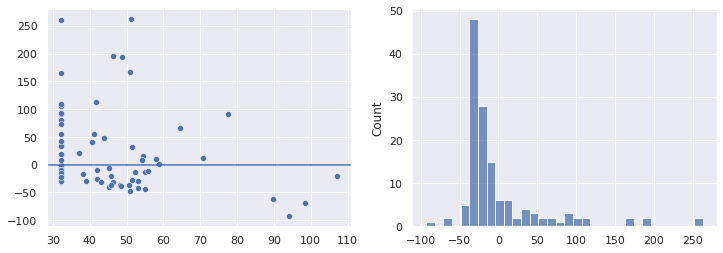

In [48]:
linear_resplot(result_not_zero)

In [49]:
df3 = df[(df['pontos'] >0) & (df['betweenness'] > 0.0000000001)]

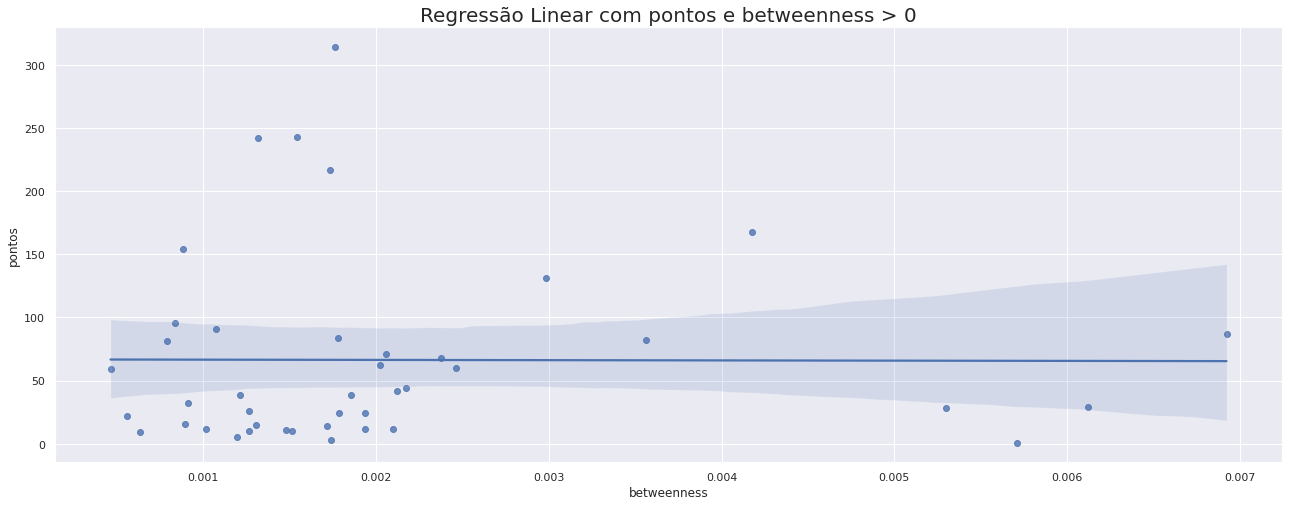

In [50]:
sns.set()
plt.figure(figsize=(22,8))
sns.regplot(x=df3['betweenness'], y=df3['pontos'])
plt.title("Regressão Linear com pontos e betweenness > 0", fontsize=20)
plt.show()

In [51]:
model = smf.ols(data=df3, formula='pontos ~ betweenness') 
result_not_zero_total = model.fit()
result_not_zero_total.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pontos   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                 0.0006329
Date:                Tue, 23 Nov 2021   Prob (F-statistic):              0.980
Time:                        00:04:43   Log-Likelihood:                -240.04
No. Observations:                  42   AIC:                             484.1
Df Residuals:                      40   BIC:                             487.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      66.8079     19.790      3.376      0.002      26.811     106.805
betweenness  -195.9025   7787.294     -0.025      0.980   -1.59e+04    1.55e+04
==============================================================================
Omnibus:                       22.121   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.413
Skew:                           1.722   Prob(JB):                     2.49e-07
Kurtosis:                       5.348   Cond. No.                         671.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

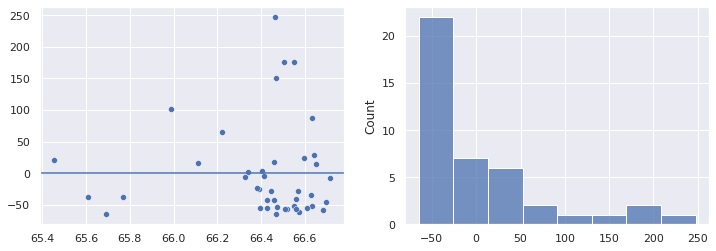

In [52]:
linear_resplot(result_not_zero_total)

In [55]:
df.sort_values(by=['betweenness'], inplace=True, ascending=False)
all_df = df[(df["pontos"] > 70) & (df["betweenness"] > 0.000000000000001)]
all_df[["name", "league", "betweenness", "pontos"]]

,name,league,betweenness,pontos
372,Spartak Moscow,Premier Liga,0.006923,87
143,FC Porto,Liga Nos,0.004175,168
87,PSV Eindhoven,Eredivisie,0.003562,82
86,Ajax Amsterdam,Eredivisie,0.002982,131
472,Chelsea FC,Premier League,0.002055,71
203,AS Monaco,Ligue 1,0.001778,84
15,Real Madrid,Primera Division,0.001765,314
314,Juventus FC,Serie A,0.001731,217
7,FC Barcelona,Primera Division,0.001541,243
342,Bayern Munich,Serie A,0.001316,242
